In [10]:
import torch
import MDAnalysis as mda
from torch_geometric.data import Data, InMemoryDataset
import numpy as np
import os
import os.path as osp
import warnings
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx
from mpl_toolkits.mplot3d import Axes3D # For 3D plotting

#from full_VGAE_egnn_clean import *

from torch.utils.data import random_split
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch
import pandas as pd
import torch_geometric.transforms as T
from torch_geometric.nn.pool import global_mean_pool
import math

from torch.utils.tensorboard import SummaryWriter
import itertools
from sklearn.preprocessing import StandardScaler


from tqdm import tqdm


## Dataset generation and preprocessing

In [11]:
import sys
sys.path.append("LIBS")
from LIBS.utils import *
from LIBS.FGVAE import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
   
# include_atom_type: bool = True,
# scale_features: bool = True,
# scale_pos: bool = True,
# initial_alignment: bool = False,

INCLUDE_ATOM_TYPE = True
SCALE_FEATURES = True   
SCALE_POS = False
INITIAL_ALIGNMENT = False

dataset = get_dataset( include_atom_type=INCLUDE_ATOM_TYPE,
                       scale_features=SCALE_FEATURES,
                       scale_pos=SCALE_POS,
                       initial_alignment=INITIAL_ALIGNMENT)

Loading dataset ...

No root directory provided, using default path ...
Successfully loaded processed data from /home/clod/Desktop/THESIS_2/FULL_ATOM/DATA/processed/data_MD_protein.pt
Positions shape: torch.Size([20032, 52, 3])
Including atom features: performing one hot encoding ...
Scaling features ...
not aligning the frames ...
Dataset created with 20032 graphs.
Number of graphs in the dataset: 20032
Number of features in the dataset: 6
Number of edges in the dataset: 102
Number of nodes in the dataset: 52
Number of features in the dataset: torch.Size([52, 6])



In [12]:
dataset_scaled = get_dataset(scale_pos=True)

#ataset_scaled[0].pos

Loading dataset ...

No root directory provided, using default path ...
Successfully loaded processed data from /home/clod/Desktop/THESIS_2/FULL_ATOM/DATA/processed/data_MD_protein.pt

Scaling positions... Max absolute position values for scaling: tensor([28.9800, 29.0000, 29.0100])
Positions shape: torch.Size([20032, 52, 3])
Including atom features: performing one hot encoding ...
Scaling features ...
not aligning the frames ...
Dataset created with 20032 graphs.
Number of graphs in the dataset: 20032
Number of features in the dataset: 6
Number of edges in the dataset: 102
Number of nodes in the dataset: 52
Number of features in the dataset: torch.Size([52, 6])



## Pretrained original model GVAE

In [54]:
# encoder - Updated based on the saved model structure
HIDDEN_ENCODER_CHANNELS = 256
OUT_ENCODER_CHANNELS = 128 
NUM_ENC_LAYERS = 9  # The saved model appears to have 9 layers (0-8)
ATTENTION_ENCODER = True
LATENT_DIM = 128
TANH_ENCODER = False
NORMALIZE_ENCODER = False

# decoder
MLP_DECODER_POS_SIZE = [256,256,128]
HIDDEN_DECODER_CHANNELS = 256
NUM_DEC_LAYERS = 9  # Should match encoder layers
ATTENTION_DECODER = True
TANH_DECODER = False
NORMALIZE_DECODER = False

model_original = FGVAE(
    encoder=EGNN_Encoder(
        in_channels=dataset[0].num_features,
        hidden_channels_egnn=HIDDEN_ENCODER_CHANNELS,
        out_channels_egnn=OUT_ENCODER_CHANNELS,
        num_egnn_layers=NUM_ENC_LAYERS,
        attention=ATTENTION_ENCODER,
        tanh=TANH_ENCODER,
        normalize=NORMALIZE_ENCODER,
        latent_dim=LATENT_DIM,
        architecture='original'
    ),
    decoder=EGNN_Decoder(
        latent_dim=LATENT_DIM,
        node_feature_dim_initial=dataset[0].num_features,
        hidden_nf=HIDDEN_DECODER_CHANNELS,
        num_egnn_layers=NUM_DEC_LAYERS,
        attention=ATTENTION_DECODER,
        tanh=TANH_DECODER,
        normalize=NORMALIZE_DECODER,
        pos_MLP_size=MLP_DECODER_POS_SIZE,
        architecture='original'
    )
)

# Try loading with strict=False to see what parameters don't match
path_model = '../RUNS/original/original_notebook/sim_noriginal/model_epoch_30.pth'
try:
    model_original.load_state_dict(torch.load(path_model), strict=False)
    print("Model loaded successfully with strict=False")
except Exception as e:
    print(f"Error loading model: {e}")

Model loaded successfully with strict=False


In [55]:
model_original.to(device)

dataloader = DataLoader(dataset_scaled, batch_size=1, shuffle=False)
model_original.eval()

recon_positions_orig = []
with torch.no_grad():
    for data in tqdm(dataloader, desc="Evaluating model"):
        data = data.to(device)
        pos_recon, _, _, _= model_original(data)
        recon_positions_orig.append(pos_recon)


Evaluating model: 100%|██████████| 20032/20032 [02:53<00:00, 115.19it/s]


Best reconstruction loss: 0.14487406611442566 for peptide index 18023


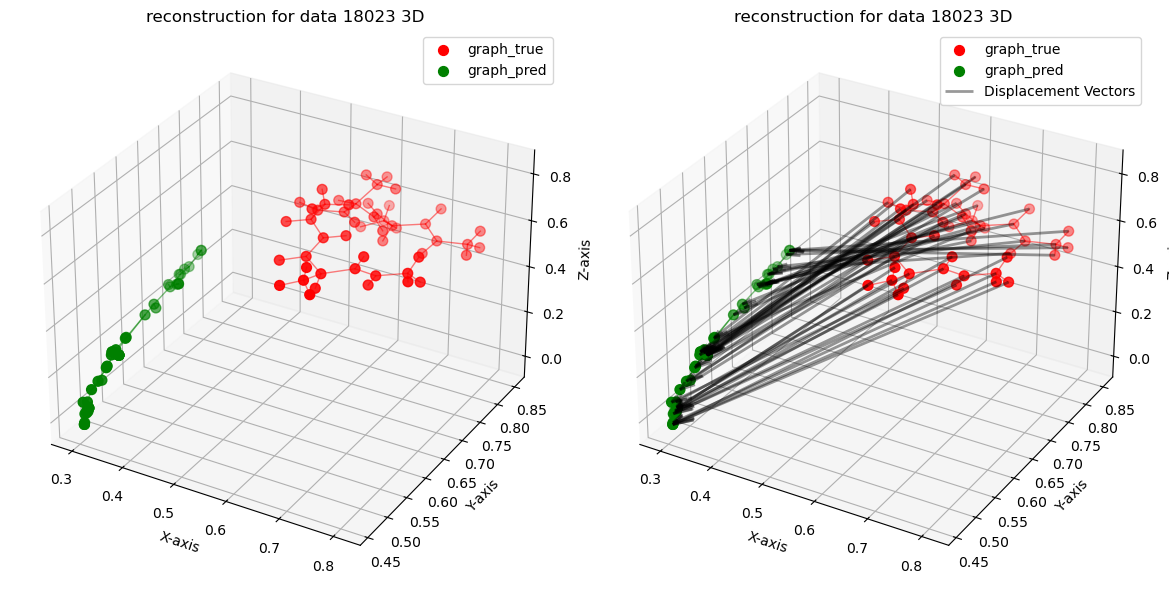

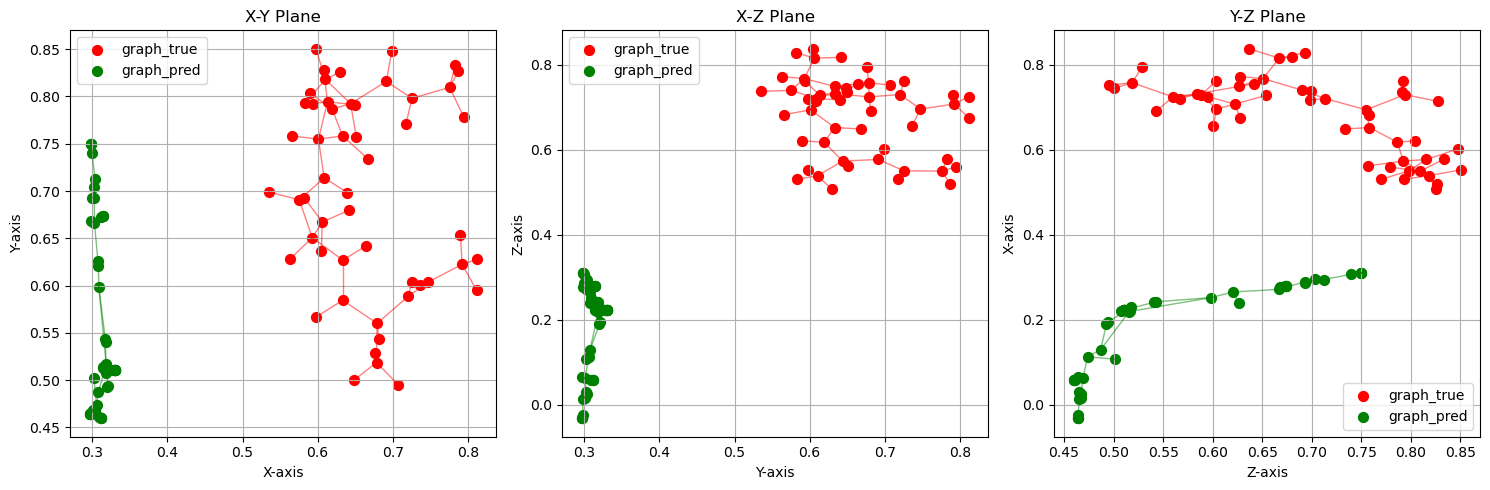

In [56]:

losses_orig = []
for i, data in enumerate(dataset_scaled):
    pos = data.pos.to(device)
    pos_recon = recon_positions_orig[i]
    
    # Calculate the loss
    loss = F.mse_loss(pos,pos_recon).item()
    losses_orig.append(loss)

best_index_orig = np.argmin(losses_orig).item()
print(f"Best reconstruction loss: {losses_orig[best_index_orig]} for peptide index {best_index_orig}")

orig_pos_recon_best = recon_positions_orig[best_index_orig].cpu()
orig_data_true_best = dataset_scaled[best_index_orig]

fig, ax = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': '3d'})

plot_graph_pred(orig_pos_recon_best, orig_data_true_best, ax=ax[0], title=f"reconstruction for data {best_index_orig} 3D", planewise=False,quiver=False)
plot_graph_pred(orig_pos_recon_best, orig_data_true_best, ax=ax[1], title=f"reconstruction for data {best_index_orig} 3D", planewise=False)
plot_graph_pred(orig_pos_recon_best, orig_data_true_best, title=f"reconstruction for data {best_index_orig} 2D", planewise=True,quiver=False)



## Pre-trained model CONDITIONED GVAE

In [13]:
# Load the models 
EPOCHS = 60

ENCODER_TYPE = 'standard'
HIDDEN_ENCODER_CHANNELS = 256
OUT_ENCODER_CHANNELS = 128 
NUM_ENC_LAYERS = 9
ATTENTION_ENCODER = True
#LATENT_DIM = 128
TANH_ENCODER = False
NORMALIZE_ENCODER = False

# decoder
MLP_DECODER_POS_SIZE = [256,256,128]
HIDDEN_DECODER_CHANNELS = 256
NUM_DEC_LAYERS = 9
ATTENTION_DECODER = True
TANH_DECODER = False
NORMALIZE_DECODER =  False

lr = 0.0001
kl_min = 0.0001
latent_dim = 128

ARCHITECTURE = 'hybrid_displacement'
FOLDER_NAME = 'test'
ENCODER_POS_PROJECTION_DIM = 64



model = FGVAE(encoder=EGNN_Encoder(
    in_channels=dataset[0].num_features,
    architecture=ARCHITECTURE,
    hidden_channels_egnn=HIDDEN_ENCODER_CHANNELS,
    pos_projection_dim=ENCODER_POS_PROJECTION_DIM,
    out_channels_egnn=OUT_ENCODER_CHANNELS,
    num_egnn_layers=NUM_ENC_LAYERS,
    attention=ATTENTION_ENCODER,
    tanh=TANH_ENCODER,
    normalize=NORMALIZE_ENCODER,
    latent_dim=latent_dim
),
decoder=EGNN_Decoder(
    latent_dim=latent_dim,
    node_feature_dim_initial=dataset[0].num_features,
    architecture=ARCHITECTURE,
    hidden_nf=HIDDEN_DECODER_CHANNELS,
    num_egnn_layers=NUM_DEC_LAYERS,
    attention=ATTENTION_DECODER,
    tanh=TANH_DECODER,
    normalize=NORMALIZE_DECODER,
    pos_MLP_size=MLP_DECODER_POS_SIZE
))

try:
    path_model = f'../JIMI_RUNS/{ARCHITECTURE}/{FOLDER_NAME}/sim_lr_{lr}_layers_{NUM_ENC_LAYERS}_kl_min_{kl_min}_latent_dim_{latent_dim}/model_epoch_{EPOCHS}.pth'
    print(f'Loading model from {path_model}')
    model.load_state_dict(torch.load(path_model))
except FileNotFoundError:
     print(f"Model file not found: {path_model}")


Loading model from ../JIMI_RUNS/hybrid_displacement/test/sim_lr_0.0001_layers_9_kl_min_0.0001_latent_dim_128/model_epoch_60.pth


In [14]:
model.to(device)
# Calculate the mean reference structure for hybrid displacement
print("Calculating mean reference structure for the hybrid model...")
all_pos = torch.stack([data.pos for data in dataset_scaled], dim=0)  # Shape: (num_graphs, num_atoms, 3)
pos_ref_single = all_pos.mean(dim=0).to(device)  # Shape: (num_atoms, 3)


dataloader = DataLoader(dataset_scaled, batch_size=1, shuffle=False)
model.eval()

recon_positions = []
with torch.no_grad():
    for data in tqdm(dataloader, desc="Evaluating model"):
        data = data.to(device)
        pos_recon, _, _, _= model(data, pos_ref=pos_ref_single)
        recon_positions.append(pos_recon)


Calculating mean reference structure for the hybrid model...


Evaluating model: 100%|██████████| 20032/20032 [02:33<00:00, 130.62it/s]


In [15]:
losses = []
for i, data in enumerate(dataset_scaled):
    pos = data.pos.to(device)
    pos_recon = recon_positions[i]
    
    # Calculate the loss
    loss = F.mse_loss(pos,pos_recon).item()
    losses.append(loss)

Best reconstruction loss: 0.0015704664401710033 for peptide index 17379


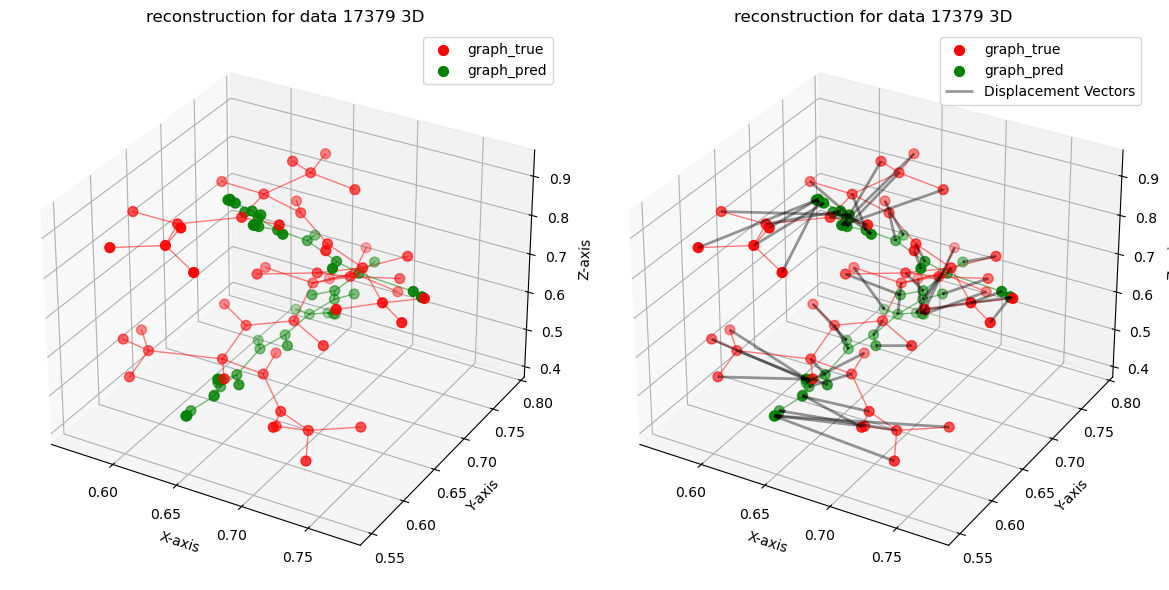

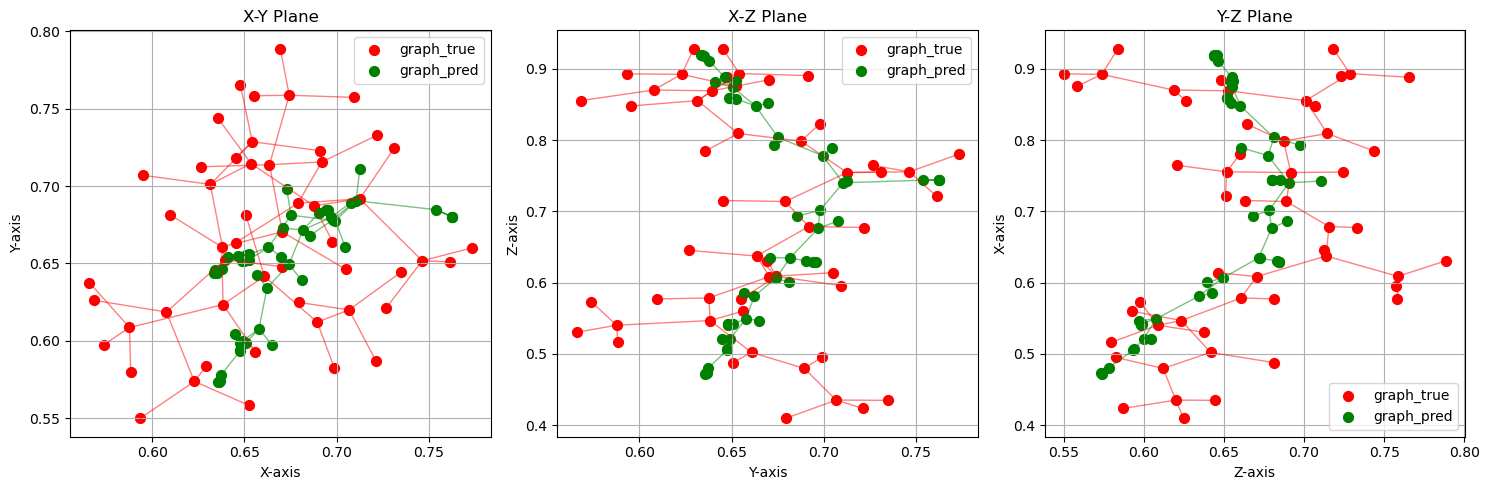

In [16]:
best_index = np.argmin(losses).item()
print(f"Best reconstruction loss: {losses[best_index]} for peptide index {best_index}")

pos_recon_best = recon_positions[best_index].cpu()
data_true_best = dataset_scaled[best_index]

fig, ax = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': '3d'})

plot_graph_pred(pos_recon_best, data_true_best, ax=ax[0], title=f"reconstruction for data {best_index} 3D", planewise=False,quiver=False)
plot_graph_pred(pos_recon_best, data_true_best, ax=ax[1], title=f"reconstruction for data {best_index} 3D", planewise=False)
plot_graph_pred(pos_recon_best, data_true_best, title=f"reconstruction for data {best_index} 2D", planewise=True,quiver=False)



For now, the features for the nodes are:
- atom type (one hot encoded)
- charge
- mass

For the edges there are no attributes

# Analysis of the distances between bonded atoms ( bond distance)

### Histogram of the distances from the original dataset

Number of edges: 51
distances shape: torch.Size([51])
distances mean: 1.2310479879379272
distances std: 0.18703922629356384


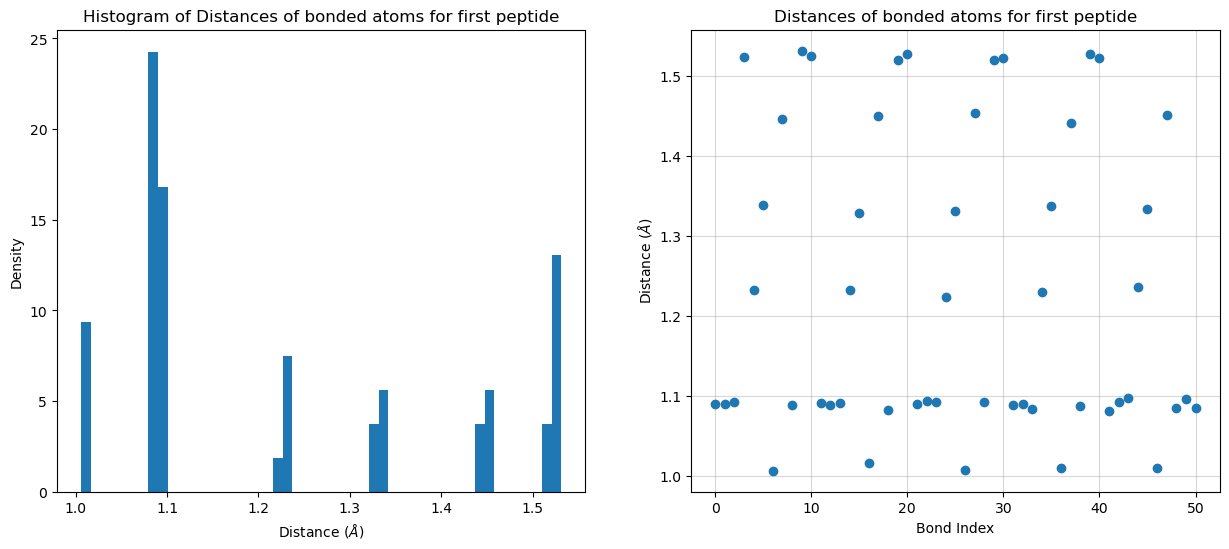

In [17]:
data = dataset[0]
pos = data.pos
edge_index = data.edge_index


fig, ax = plt.subplots(1,2, figsize=(15,6))
# plot an histogram of the distances between atoms

edge_index_single = edge_index[:, edge_index[0] < edge_index[1]]
distances = torch.norm(pos[edge_index_single[0]] - pos[edge_index_single[1]], dim=1)

print("Number of edges:", edge_index_single.shape[1])
print("distances shape:", distances.shape)
print("distances mean:", distances.mean().item())
print("distances std:", distances.std().item())

ax[0].hist(distances.numpy(), bins=50, density=True)
ax[0].set_xlabel(r'Distance ($\AA$)')
ax[0].set_ylabel('Density')
ax[0].set_title('Histogram of Distances of bonded atoms for first peptide')


ax[1].plot(np.arange(len(distances)), distances.numpy(), 'o')
ax[1].set_xlabel('Bond Index')
ax[1].set_ylabel(r'Distance ($\AA$)')
ax[1].set_title('Distances of bonded atoms for first peptide')
ax[1].grid(alpha=0.5)
plt.show()



Typical length of the bonds inside tetraalanine
| **Bond Type**      | **Distance (Å)** |
| ------------------ | ---------------- |
| N–H                | \~1.01 Å         |
| C–N (peptide bond) | \~1.33 Å         |
| C=O                | \~1.23 Å         |
| C–C                | \~1.52 – 1.54 Å  |
| C–H                | \~1.09 Å         |
| O–H                | \~0.96 Å         |



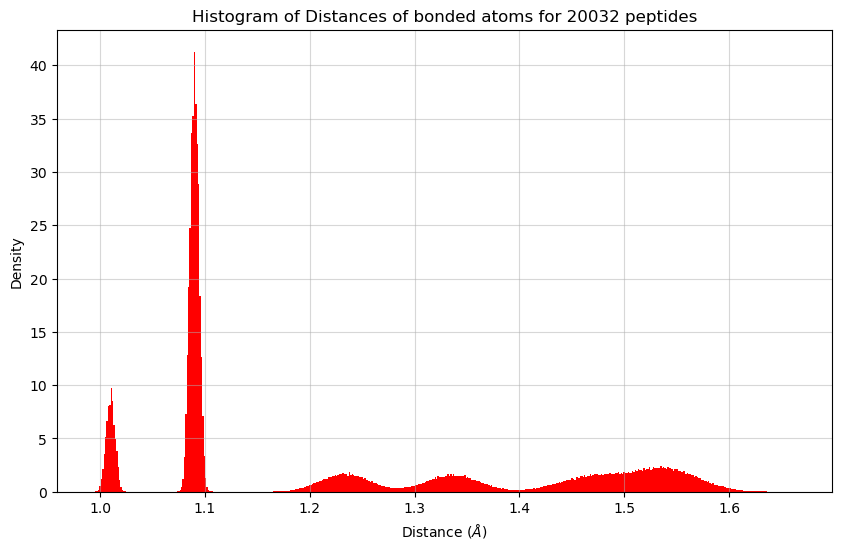

distances shape: torch.Size([1021632])
Distances mean: 1.2361741065979004
Distances std: 0.19184741377830505


In [32]:
# here I can use edge_index_single from before since it the same for all peptides
true_distances = []
n_peptides = len(dataset)
for data in dataset[:n_peptides]:
    pos = data.pos
    
    # plot an histogram of the distances between atoms
    true_distances.append(torch.norm(pos[edge_index_single[0]] - pos[edge_index_single[1]], dim=1))

true_distances = torch.cat(true_distances)
fig_original =plt.figure(figsize=(10, 6))
plt.hist(true_distances, bins=500, color='red', density=True)
plt.xlabel(r'Distance ($\AA$)')
plt.ylabel('Density')
plt.title(f'Histogram of Distances of bonded atoms for {n_peptides} peptides')
plt.grid(alpha=0.5)
plt.show()

print ("distances shape:", true_distances.shape)
print("Distances mean:", true_distances.mean().item())
print("Distances std:", true_distances.std().item())

## Histogram of the reconstructed distances

Number of peptides: 20032


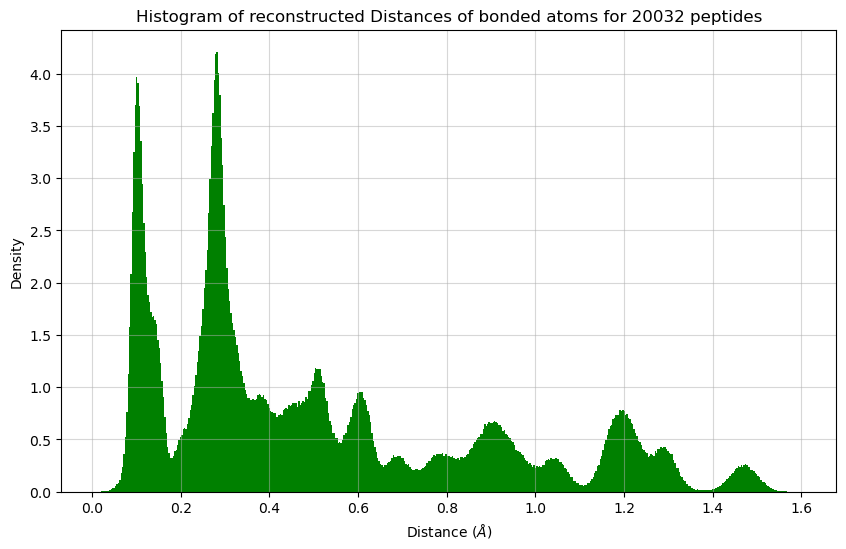

distances shape: torch.Size([1021632])
Distances mean: 0.5065867304801941
Distances std: 0.3734614849090576


In [33]:
# here I can use edge_index_single from before since it the same for all peptides
# rescale back to original scale
max_pos = torch.tensor([28.9800, 29.0000, 29.0100])

pos_recon_rescaled_tensor = torch.stack(recon_positions, dim=0)* max_pos.to(device)
# Move to CPU and convert to numpy
pos_recon_rescaled_tensor = pos_recon_rescaled_tensor.cpu()
pos_recon_rescaled = pos_recon_rescaled_tensor.cpu().numpy()

pos_true = torch.stack([data.pos for data in dataset], dim=0) 

distances = []
n_peptides = pos_recon_rescaled_tensor.shape[0]
print("Number of peptides:", n_peptides)

# plot an histogram of the distances between atoms
for pos in pos_recon_rescaled_tensor:

    # plot an histogram of the distances between atoms
    distances.append(torch.norm(pos[edge_index_single[0]] - pos[edge_index_single[1]], dim=1))

distances = torch.cat(distances)

fig_reconstructed = plt.figure(figsize=(10, 6))
plt.hist(distances, bins=500, color = 'green', density=True)
plt.xlabel(r'Distance ($\AA$)')
plt.ylabel('Density')
plt.title(f'Histogram of reconstructed Distances of bonded atoms for {n_peptides} peptides')
plt.grid(alpha=0.5)
plt.show()

print ("distances shape:", distances.shape)
print("Distances mean:", distances.mean().item())
print("Distances std:", distances.std().item())

## Comparison

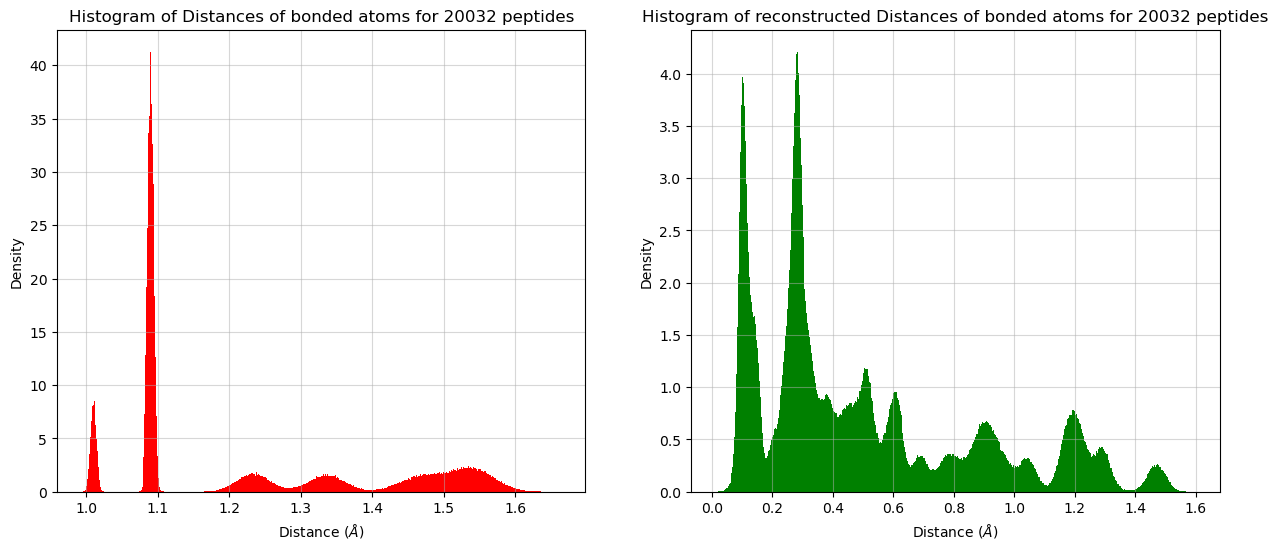

In [31]:
# plot fig_original and fig_reconstructed side by side
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
ax[0].hist(true_distances, bins=500, color ='red', density=True)
ax[0].set_xlabel(r'Distance ($\AA$)')
ax[0].set_ylabel('Density')
ax[0].set_title(f'Histogram of Distances of bonded atoms for {n_peptides} peptides')
ax[0].grid(alpha=0.5)
ax[1].hist(distances, bins=500, color ='green', density=True)
ax[1].set_xlabel(r'Distance ($\AA$)')
ax[1].set_ylabel('Density')
ax[1].set_title(f'Histogram of reconstructed Distances of bonded atoms for {n_peptides} peptides')
ax[1].grid(alpha=0.5)
plt.show()


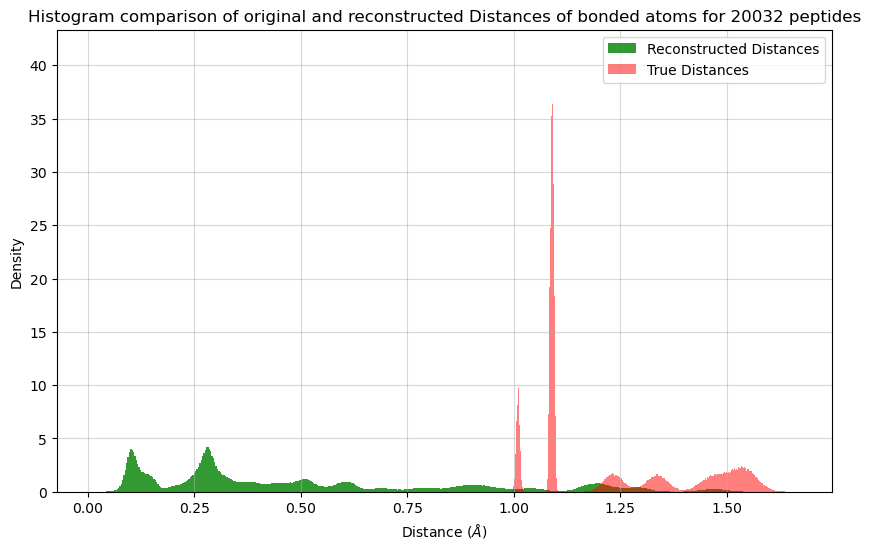

In [30]:
plt.figure(figsize=(10, 6))
plt.hist(distances, bins=500, density=True, alpha=0.8, color='green', label='Reconstructed Distances')
plt.hist(true_distances, bins=500, density=True, alpha=0.5, color='red', label='True Distances')
plt.xlabel(r'Distance ($\AA$)')
plt.ylabel('Density')
plt.title(f'Histogram comparison of original and reconstructed Distances of bonded atoms for {n_peptides} peptides')
plt.legend()
plt.grid(alpha=0.5)
plt.show()


**Typical atomic size**

| **Element**      | **Covalent Radius** (Å) | **Van der Waals Radius** (Å) |
| ---------------- | ----------------------- | ---------------------------- |
| **Hydrogen (H)** | \~0.31 Å                | \~1.20 Å                     |
| **Carbon (C)**   | \~0.76 Å                | \~1.70 Å                     |
| **Nitrogen (N)** | \~0.71 Å                | \~1.55 Å                     |
| **Oxygen (O)**   | \~0.66 Å                | \~1.52 Å                     |

- Covalent radius: Half the distance between two atoms of the same kind bonded together.

- Van der Waals radius: Effective size an atom appears to occupy in space; important for non-bonded interactions.
